## Classification with Neural Nets in PyTorch

In [1]:
import sklearn

In [2]:

from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create samples
X,y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [3]:
len(X),len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFrame with Pandas
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],"X2": X[:,1],"label":y})

In [6]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


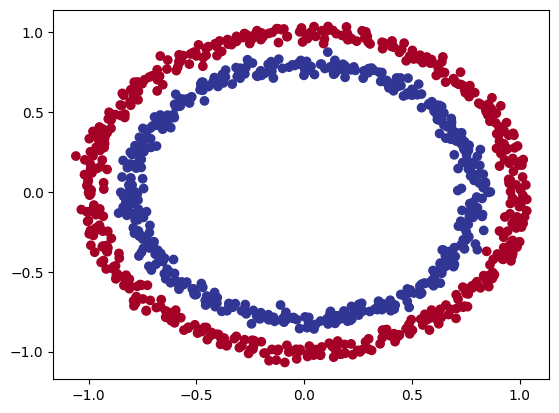

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [8]:
X.shape,y.shape
type(X),type(y)

(numpy.ndarray, numpy.ndarray)

In [9]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
type(X)

torch.Tensor

In [10]:
# Train/Test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

In [11]:
type(X_train)

torch.Tensor

In [12]:
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device:{device}")

Using device:cpu


In [13]:
# Model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2,out_features=5) # takes in 2 features and upscales to 5
    self.layer_2 = nn.Linear(in_features=5,out_features=1) # takes in 5 features and outputs 1

  # Define forward pass
  def forward(self,x):
    return self.layer_2(self.layer_1(x))

# Instantiate model
model_0 = CircleModelV0().to(device)

In [14]:
# Replicate the model using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [15]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4102,  0.0279],
                      [ 0.3535,  0.2469],
                      [ 0.4379,  0.3918],
                      [-0.0696, -0.2588],
                      [-0.4988, -0.5658]])),
             ('0.bias', tensor([ 0.1408, -0.4394,  0.0100,  0.6846, -0.3040])),
             ('1.weight',
              tensor([[ 0.1094, -0.2791, -0.4170,  0.1393,  0.0255]])),
             ('1.bias', tensor([-0.3502]))])

In [16]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [17]:
# Training and Testing Loop
torch.manual_seed(42)

# Number of epochs
epochs=100

# Data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Training
  model_0.train()

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))


  # Calculate the loss
  loss = loss_fn(y_logits,y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  # Testing
  model_0.eval()

  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Loss
    test_loss = loss_fn(test_logits,y_test)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.7043916583061218 | Test loss: 0.6947566270828247
Epoch: 10 | Loss: 0.7008709907531738 | Test loss: 0.692482590675354
Epoch: 20 | Loss: 0.6986843943595886 | Test loss: 0.6914324760437012
Epoch: 30 | Loss: 0.6972135901451111 | Test loss: 0.6909856200218201
Epoch: 40 | Loss: 0.6961727738380432 | Test loss: 0.6908576488494873
Epoch: 50 | Loss: 0.6954135298728943 | Test loss: 0.6909063458442688
Epoch: 60 | Loss: 0.6948498487472534 | Test loss: 0.6910548210144043
Epoch: 70 | Loss: 0.6944266557693481 | Test loss: 0.6912577748298645
Epoch: 80 | Loss: 0.6941065788269043 | Test loss: 0.6914877891540527
Epoch: 90 | Loss: 0.6938633918762207 | Test loss: 0.6917275786399841


In [18]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})




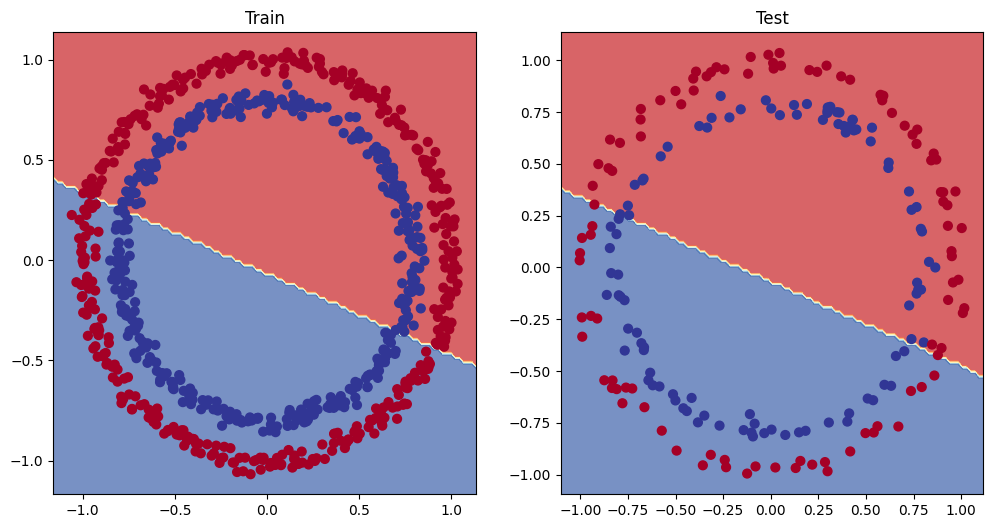

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)


In [29]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [30]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [36]:
# Fit the model
torch.manual_seed(42)
epochs = 1500

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits


    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)


    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.56673 | Test Loss: 0.57254
Epoch: 100 | Loss: 0.47950 | Test Loss: 0.49769
Epoch: 200 | Loss: 0.36822 | Test Loss: 0.40393
Epoch: 300 | Loss: 0.25253 | Test Loss: 0.30127
Epoch: 400 | Loss: 0.17053 | Test Loss: 0.21976
Epoch: 500 | Loss: 0.12111 | Test Loss: 0.16421
Epoch: 600 | Loss: 0.09074 | Test Loss: 0.12682
Epoch: 700 | Loss: 0.07068 | Test Loss: 0.10281
Epoch: 800 | Loss: 0.05752 | Test Loss: 0.08644
Epoch: 900 | Loss: 0.04837 | Test Loss: 0.07454
Epoch: 1000 | Loss: 0.04164 | Test Loss: 0.06568
Epoch: 1100 | Loss: 0.03618 | Test Loss: 0.05968
Epoch: 1200 | Loss: 0.03197 | Test Loss: 0.05450
Epoch: 1300 | Loss: 0.02866 | Test Loss: 0.05015
Epoch: 1400 | Loss: 0.02599 | Test Loss: 0.04655


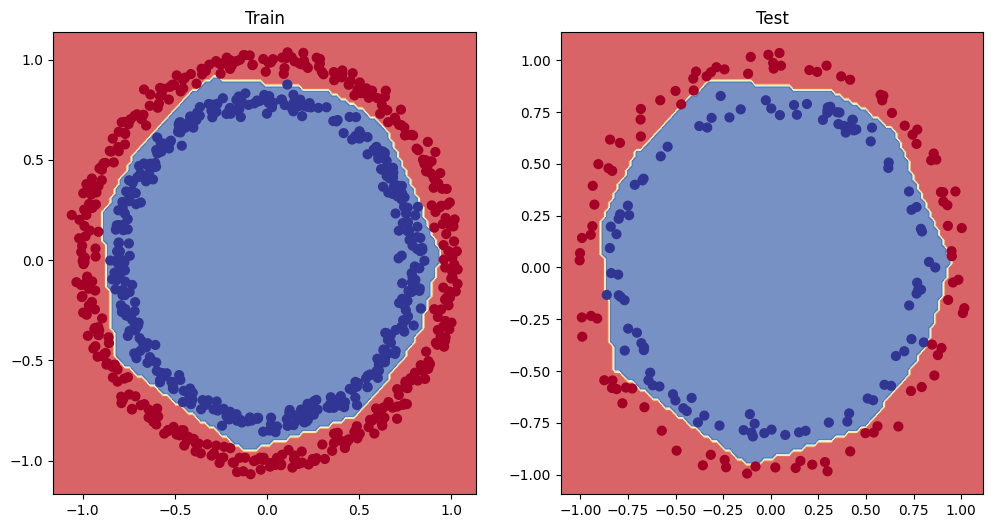

In [37]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)
